# 3 Modeling

# 0) Import Modules

In [16]:
import os
import pandas
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge, ElasticNet 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

# 1) Load Data

In [4]:
'''
Load the final data after two processing iterations.

The raw data was initially cleaned by Ant which he put into airbnb_no_impute.csv which was then processed by
Aren in the FeatureSelection.ipynb which created the final data used for modelling.
'''

data = pd.read_csv('C:\\Users\\eelis\\ds-ga1001\\data\\airbnb_eelis.csv')


In [4]:
os.chdir("/Users/anhthyngo/ds-ga1001-master/")
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')) + '/data/'
listings = datadir + 'airbnb_final.csv.zip'
print(listings)

/Users/anhthyngo/ds-ga1001-master/data/airbnb_final.csv.zip


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
zf = ZipFile(listings) 
data = pd.read_csv(zf.open("airbnb_final.csv"), low_memory=False)
#data.drop('zipcode', axis = 1, inplace=True)
data.head(5)


,latitude,longitude,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,minimum_minimum_nights,minimum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,reviews_per_month,extra_people,cleaning_fee,security_deposit,neighbourhood_group_cleansed_Manhattan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price
0,40.72764,-73.97949,2,1.0,1.0,2,30,30,30.0,12,42,72,347,94,0,95.0,0.73,15.0,75.0,500.0,1,1,0,0,4.753590
1,40.80316,-73.96545,2,1.0,1.0,1,5,5,5.0,1,1,1,40,54,12,93.0,0.43,0.0,75.0,450.0,1,1,0,0,4.905275
2,40.66829,-73.98779,2,1.0,1.0,1,4,4,4.0,6,29,59,332,171,14,94.0,1.35,22.0,67.0,200.0,0,0,1,0,4.488636
3,40.79826,-73.96113,1,1.0,1.0,1,2,2,2.0,3,24,54,329,116,25,92.0,0.92,40.0,80.0,200.0,1,0,1,0,4.442651
4,40.67592,-73.94694,4,1.0,1.0,3,3,3,3.0,0,8,34,34,62,53,96.0,4.39,50.0,70.0,500.0,0,1,0,0,4.595120


(array([ 338.,  814.,  925., 1054., 1314., 1727., 1139., 1364., 1598.,
        1201.,  847.,  535.,  213.,  168.,  135.]),
 array([3.55534806, 3.73524678, 3.91514549, 4.09504421, 4.27494293,
        4.45484164, 4.63474036, 4.81463908, 4.99453779, 5.17443651,
        5.35433523, 5.53423394, 5.71413266, 5.89403138, 6.07393009,
        6.25382881]),
 <a list of 15 Patch objects>)

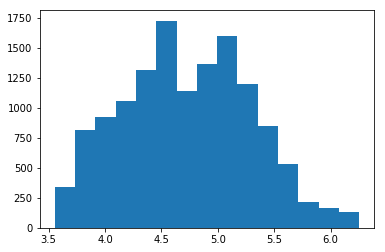

In [6]:
plt.hist(data['price'],bins = 15)

In [7]:
'''
Split data into X and y.
'''

y = data['price']
X = data.drop('price',axis = 1)

In [8]:
'''
Split data into testing and final. 

**NOTE**
The final dataset will be used only ONCE for the best performing model which we determine on the validation set. 
X_final and y_final will only be used at the very end of the script. X_train and y_train will contain BOTH the training AND
validation sets.
'''

X_train, X_final, y_train, y_final = train_test_split(X, y, test_size=0.2, random_state = 42)

# 2) Modeling

# i) Baseline

In [9]:
'''
Using just a standard linear regression in order to get a baseline. 10 fold cv was used in order to evaluate the performance 
and the MSE was plotted on the graph.
'''

#Create model.
lin_reg = LinearRegression()

#Run 10 fold CV using MSE.
scores = cross_val_score(lin_reg, X_train, y_train,scoring="neg_mean_squared_error", cv = 10)
scores =np.absolute(scores)

#Print mean and std.
print(scores.mean())
print(scores.std())

0.10265544503291894
0.005452969683675555


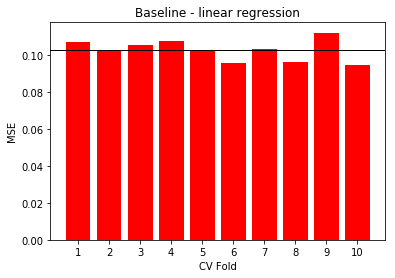

In [14]:
'''
Plot the MSE scores for each fold well as the mean MSE value as a horizontal line.
'''
#Set x and y axis
vals = [i for i in range(1,len(scores)+1)]
plt.bar(vals,scores, color = 'red')

#Formatting
plt.xlabel('CV Fold')
plt.ylabel('MSE')
plt.xticks(vals)
plt.title('Baseline - linear regression')

#Plot mean as horizontal line.
plt.axhline(y=scores.mean(),linewidth=1, color='k')

# ii) Improvements over baseline

# Model 1: Elastic Net

In [17]:
'''
Apply elastic net in a pipeline that first scales the data and then searches through the state space
via a randomized grid search (in order to limit computation time.
'''

#Create pipeline steps. Good idea to scale features for Elastic net.
steps = [('scaler', StandardScaler()),
         ('en', ElasticNet())]

#Now set up the pipeline
pipeline = Pipeline(steps)

#Set up the parameter grid in a dictionary format.
parameters = dict(en__alpha = [0,0.0001,0.005,0.01,0.05,0.1,0.2],
                  en__l1_ratio = [0,0.25,0.5,0.75,1])

#Run grid search.
search_1 = GridSearchCV(pipeline, param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')
search_1.fit(X_train, y_train)

#Print the score and parameter of the best model.
print("Best parameter (CV score=%0.3f):" % search_1.best_score_)
print(search_1.best_params_)

Best parameter (CV score=-0.103):
{'en__alpha': 0.0001, 'en__l1_ratio': 1}


# Model 2: PCA and elastic net

In [19]:
'''
Evaluate if applying PCA followed by Elastic Net could lead to better performance.
'''
#Create Pipeline with Scaling, PCA and ElasticNet.
pipeline = Pipeline(steps=[('scaler', StandardScaler()),('pca', PCA()), ('elastic', ElasticNet())])

#Set parameter grid.
parameters = dict(pca__n_components=[5,10,20,24],
    elastic__alpha=[0,0.0001,0.005,0.01,0.05,0.1,0.2],
    elastic__l1_ratio =[0,0.25,0.5,0.75,1]
)

#Run Random Grid Search.
search_2 = GridSearchCV(pipeline, param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')
search_2.fit(X_train, y_train)

#Print the score of the best model.
print("Best parameter (CV score=%0.3f):" % search_2.best_score_)
print(search_2.best_params_)

Best parameter (CV score=-0.103):
{'elastic__alpha': 0.0001, 'elastic__l1_ratio': 1, 'pca__n_components': 24}


# Model 3: Random Forest

In [21]:
'''
Apply Random Forest.
'''

#No need to scale features for Random Forest.
steps = [('rfr', RandomForestRegressor())]

#Set up the pipeline
pipeline = Pipeline(steps)

#Set up the parameter grid. Not possible to check all parameters since it would take too long.
parameters = dict(rfr__n_estimators = [50,100,200,1000],
                  rfr__max_features = [1, 5, 20, 24],)

#Run grid search
search_3 = GridSearchCV(pipeline, param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error')
search_3.fit(X_train, y_train)

#Print the score of the best model
print("Best parameter (CV score=%0.3f):" % search_3.best_score_)
print(search_3.best_params_)

Best parameter (CV score=-0.083):
{'rfr__max_features': 20, 'rfr__n_estimators': 1000}


# Model 4 Gradient Boosting

In [22]:
'''
Apply Gradient Boosting.
'''
#No need to scale features for Gradient Boosting.
steps = [('gbr',GradientBoostingRegressor())]

#Set up the pipeline
pipeline = Pipeline(steps)

#Set up the parameter grid. Gradient boosting is quite robust against overfitting so used many estimators.
parameters = dict(gbr__n_estimators = [50,100,200,1000],
                  gbr__max_depth = [1,3,5,10],)

#Run another grid search.
search_4 = GridSearchCV(pipeline, param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error')
#search_4 = RandomizedSearchCV(pipeline, param_distributions = parameters,n_iter =10, cv = 3, scoring = 'neg_mean_squared_error')
search_4.fit(X_train, y_train)

#Print the score of the best model.
print("Best parameter (CV score=%0.3f):" % search_4.best_score_)
print(search_4.best_params_)

Best parameter (CV score=-0.081):
{'gbr__max_depth': 5, 'gbr__n_estimators': 200}


# Model 5 KKN

In [23]:
'''
Use KNN as a non-parametric method.
'''

steps = [('knn',KNeighborsRegressor())]

#Set up the pipeline
pipeline = Pipeline(steps)

#Set up the parameter grid. Gradient boosting is quite robust against overfitting so used many estimators.
parameters = dict(knn__n_neighbors  = [1,3,5,10,20,50,100,150],)

#Run another grid search.
search_5 = GridSearchCV(pipeline, param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')
search_5.fit(X_train, y_train)

#Print the score of the best model.
print("Best parameter (CV score=%0.3f):" % search_5.best_score_)
print(search_5.best_params_)

Best parameter (CV score=-0.208):
{'knn__n_neighbors': 20}


# Model comparison

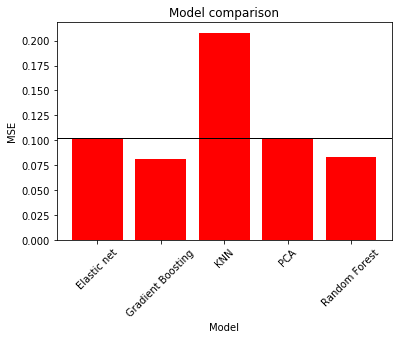

In [24]:
'''
Compare each of the best performing models.
'''
#Add models to list.
model_list=[]
model_list.append(-search_1.best_score_)
model_list.append(-search_2.best_score_)
model_list.append(-search_3.best_score_)
model_list.append(-search_4.best_score_)
model_list.append(-search_5.best_score_)

model_name = ['Elastic net','PCA','Random Forest','Gradient Boosting','KNN']

plt.bar(model_name,model_list, color = 'red')

#Formatting
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation='45')
plt.title('Model comparison')

#Plot baseline mean as horizontal line.
plt.axhline(y=scores.mean(),linewidth=1, color='k')

# Evaluate best model on testing data

In [25]:
best_estimator = search_1.best_estimator_
y_pred = best_estimator.predict(X_final)
final_loss = mean_squared_error(y_final, y_pred)